## Three Stock Monte

This exercise tests your ability to retrieve stock price data using the Alpaca API and simulate multiple portfolio compositions using Monte Carlo Simulation.

### Import Dependencies

In [1]:
# Import libraries and dependencies
import os
import pandas as pd
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

### Get Past ~4 Year's Worth of Stock Price Data via Alpaca API Call

In [4]:
# Set timeframe to "1Day"
timeframe = "1Day"

# Set start and end datetimes between now and 4 years ago.
start_date = pd.Timestamp("2017-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-05-01", tz="America/New_York").isoformat()

# Set the ticker information
tickers = ["T","NKE","XOM"]

# Get 4 year's worth of historical price data
# HINT: Set "limit" to at least 10000 so all ticker rows are captured from get_bars()
df_ticker = api.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit = 10000
).df


# Display sample data
df_ticker.head()

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2017-05-01 04:00:00+00:00,54.99,55.45,54.98,30493,55.43,5361441,55.190028,NKE
2017-05-02 04:00:00+00:00,55.07,55.16,54.79,41590,55.12,7792518,54.974022,NKE
2017-05-03 04:00:00+00:00,54.53,55.30,54.40,48477,55.17,10746396,54.612038,NKE
2017-05-04 04:00:00+00:00,54.47,54.83,54.20,39262,54.68,7310669,54.501759,NKE
2017-05-05 04:00:00+00:00,53.95,54.50,53.56,57957,54.41,14261080,53.898559,NKE


> Note: We're going to simulate five years of growth below, and so we might want to pull at least five years of data in order to do that. But we pulled four because of Alpaca's rate limits--we can only pull 1,000 rows per ticker at a time (approximately four years of data, with 252 tradable days per year). If we pull data with repeated calls in a `for` loop, however, we can get quite a few more years than what we've got above.  

In [5]:
# Reorganize the DataFrame
# Separate ticker data
T = df_ticker[df_ticker["symbol"]=="T"].drop("symbol", axis=1)
NKE = df_ticker[df_ticker["symbol"]=="NKE"].drop("symbol", axis=1)
XOM = df_ticker[df_ticker["symbol"]=="XOM"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_ticker = pd.concat([T, NKE, XOM], axis=1, keys=["T","NKE","XOM"])

# Display sample data
df_ticker.head()

T                                             \
                           close   high    low trade_count   open    volume   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.10  39.70  39.06       95236  39.68  27137598   
2017-05-02 04:00:00+00:00  38.95  39.22  38.88       86239  39.14  26346738   
2017-05-03 04:00:00+00:00  38.40  38.98  38.15      113921  38.94  36621125   
2017-05-04 04:00:00+00:00  38.01  38.41  37.63      118192  38.41  32681751   
2017-05-05 04:00:00+00:00  38.56  38.71  38.03       82036  38.08  23262074   

                                        NKE                ...         \
                                vwap  close   high    low  ...   open   
timestamp                                                  ...          
2017-05-01 04:00:00+00:00  39.283136  54.99  55.45  54.98  ...  55.43   
2017-05-02 04:00:00+00:00  38.996146  55.07  55.16  54.79  ...  55.12   
2017-05-03 04:00:00+00:00  38.426498  54.53  55.30  54.40  ...  55.17   
2017-05-04 04:00:00+00:00  37.969998  54.47  54.83  54.20  ...  54.68   
2017-05-05 04:00:00+00:00  38.426797  53.95  54.50  53.56  ...  54.41   

                                                  XOM                  \
                             volume       vwap  close     high    low   
timestamp                                                               
2017-05-01 04:00:00+00:00   5361441  55.190028  82.06  82.2100  81.48   
2017-05-02 04:00:00+00:00   7792518  54.974022  82.05  82.5900  81.90   
2017-05-03 04:00:00+00:00  10746396  54.612038  82.70  83.0699  81.91   
2017-05-04 04:00:00+00:00   7310669  54.501759  81.64  82.3600  81.40   
2017-05-05 04:00:00+00:00  14261080  53.898559  82.02  82.2350  81.61   

                                                                   
                          trade_count   open    volume       vwap  
timestamp                                                          
2017-05-01 04:00:00+00:00       49225  81.51   9769374  81.945427  
2017-05-02 04:00:00+00:00       54236  82.14  10044837  82.185586  
2017-05-03 04:00:00+00:00       57309  81.95  11189766  82.631674  
2017-05-04 04:00:00+00:00       86290  82.29  17175853  81.728301  
2017-05-05 04:00:00+00:00       59390  81.64  11203370  81.940459  

[5 rows x 21 columns]

### Simulate five year portfolio growth with evenly-distributed stock investments

In [6]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
MC_even_dist = MCSimulation(
    portfolio_data= df_ticker,
    weights= [.33, .33, .33],
    num_simulation= 100,
    num_trading_days= 252*5
)

# Print the simulation input data
MC_even_dist.portfolio_data.head()

T                                             \
                           close   high    low trade_count   open    volume   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.10  39.70  39.06       95236  39.68  27137598   
2017-05-02 04:00:00+00:00  38.95  39.22  38.88       86239  39.14  26346738   
2017-05-03 04:00:00+00:00  38.40  38.98  38.15      113921  38.94  36621125   
2017-05-04 04:00:00+00:00  38.01  38.41  37.63      118192  38.41  32681751   
2017-05-05 04:00:00+00:00  38.56  38.71  38.03       82036  38.08  23262074   

                                                     NKE         ...  \
                                vwap daily_return  close   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.283136          NaN  54.99  55.45  ...   
2017-05-02 04:00:00+00:00  38.996146    -0.003836  55.07  55.16  ...   
2017-05-03 04:00:00+00:00  38.426498    -0.014121  54.53  55.30  ...   
2017-05-04 04:00:00+00:00  37.969998    -0.010156  54.47  54.83  ...   
2017-05-05 04:00:00+00:00  38.426797     0.014470  53.95  54.50  ...   

                                                     XOM                  \
                                vwap daily_return  close     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.190028          NaN  82.06  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.974022     0.001455  82.05  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.612038    -0.009806  82.70  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501759    -0.001100  81.64  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.898559    -0.009547  82.02  82.2350  81.61   

                                                                                
                          trade_count   open    volume       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00       49225  81.51   9769374  81.945427          NaN  
2017-05-02 04:00:00+00:00       54236  82.14  10044837  82.185586    -0.000122  
2017-05-03 04:00:00+00:00       57309  81.95  11189766  82.631674     0.007922  
2017-05-04 04:00:00+00:00       86290  82.29  17175853  81.728301    -0.012817  
2017-05-05 04:00:00+00:00       59390  81.64  11203370  81.940459     0.004655  

[5 rows x 24 columns]

In [7]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
MC_even_dist.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.979413,0.980632,1.002756,1.002298,1.000813,0.997367,1.005530,0.992425,0.988427,0.979855,...,1.006351,1.011781,0.999862,0.989011,0.991283,0.991678,0.999478,0.984937,1.011811,0.991320
2,0.967349,0.986964,1.002868,1.007915,1.003345,1.015052,1.024443,0.994683,0.989548,0.983945,...,1.011514,1.021343,0.991077,0.996864,1.014088,0.982643,1.006849,0.991974,1.020580,1.004163
3,0.965257,0.961039,0.994878,1.003811,1.009756,1.020367,1.026796,1.004997,0.999877,0.986207,...,1.021844,1.031197,0.990115,0.975513,1.021630,0.976277,1.014698,0.991151,1.025097,1.003315
4,0.971614,0.946869,1.006550,1.008471,0.993636,1.044242,1.013608,0.999740,1.012247,0.973172,...,1.038182,1.016769,0.992303,0.968560,1.029052,0.989361,1.014148,0.978884,1.034907,0.991974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.319298,0.994805,2.030444,2.035642,1.529880,1.182544,1.214244,1.050037,2.053808,0.523043,...,1.415711,1.641580,0.794175,0.902581,0.888960,2.022789,1.146686,1.782355,2.255896,0.734801
1257,1.315614,0.999487,2.048267,1.974812,1.507801,1.173757,1.214264,1.053038,2.080503,0.523010,...,1.381193,1.673376,0.795258,0.893224,0.899311,2.022004,1.140705,1.790667,2.254793,0.728220
1258,1.287188,0.997422,2.057667,1.962076,1.513793,1.175552,1.230706,1.051074,2.066347,0.519965,...,1.393936,1.644219,0.788807,0.908536,0.905778,2.017127,1.151646,1.779788,2.239151,0.726007
1259,1.278742,0.995068,2.043192,1.972750,1.484180,1.178372,1.230388,1.061244,2.063288,0.525117,...,1.392857,1.667645,0.800926,0.903624,0.913706,2.018360,1.162066,1.778710,2.265265,0.716048


<Axes: title={'center': '100 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

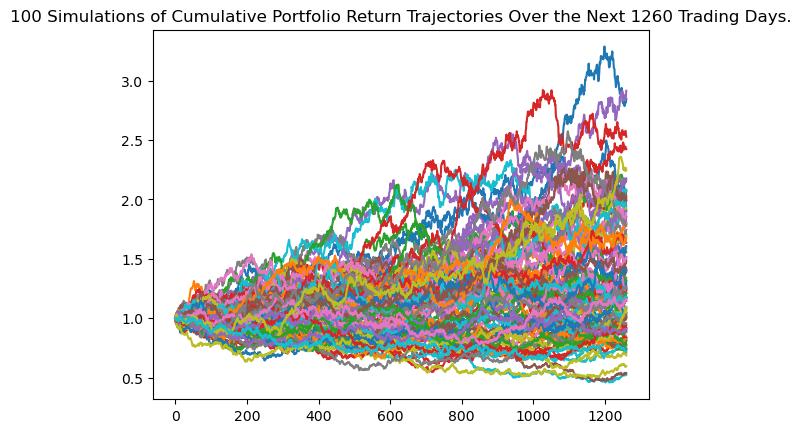

In [8]:
# Plot simulation outcomes
MC_even_dist.plot_simulation()

<Axes: title={'center': 'Distribution of Final Cumuluative Returns Across All 100 Simulations'}, ylabel='Frequency'>

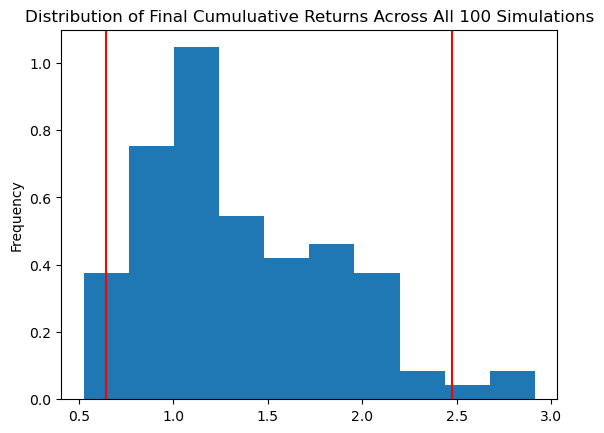

In [9]:
# Plot probability distribution and confidence intervals
MC_even_dist.plot_distribution()

In [10]:
# Fetch summary statistics from the Monte Carlo simulation results
even_tbl = MC_even_dist.summarize_cumulative_return()

# Print summary statistics
print(even_tbl)

count           100.000000
mean              1.346102
std               0.514064
min               0.525769
25%               0.956150
50%               1.226156
75%               1.710420
max               2.914258
95% CI Lower      0.641431
95% CI Upper      2.477856
Name: 1260, dtype: float64


In [11]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments stocks
ci_lower = round(0.7 * 15000, 2)
ci_upper = round(2.4 * 15000, 2)

# Print results
print(f'There is a 95% chance to make within ${ci_lower} and ${ci_upper} with an initial investment of $15000')

There is a 95% chance to make within $10500.0 and $36000.0 with an initial investment of $15000


### Simulate five year portfolio growth with 60% AT&T stock

In [12]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_att = MCSimulation(
    portfolio_data= df_ticker,
    weights= [.60, .20, .20],
    num_simulation= 100,
    num_trading_days= 252*5
)

# Print the simulation input data
MC_att.portfolio_data.head()

T                                             \
                           close   high    low trade_count   open    volume   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.10  39.70  39.06       95236  39.68  27137598   
2017-05-02 04:00:00+00:00  38.95  39.22  38.88       86239  39.14  26346738   
2017-05-03 04:00:00+00:00  38.40  38.98  38.15      113921  38.94  36621125   
2017-05-04 04:00:00+00:00  38.01  38.41  37.63      118192  38.41  32681751   
2017-05-05 04:00:00+00:00  38.56  38.71  38.03       82036  38.08  23262074   

                                                     NKE         ...  \
                                vwap daily_return  close   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.283136          NaN  54.99  55.45  ...   
2017-05-02 04:00:00+00:00  38.996146    -0.003836  55.07  55.16  ...   
2017-05-03 04:00:00+00:00  38.426498    -0.014121  54.53  55.30  ...   
2017-05-04 04:00:00+00:00  37.969998    -0.010156  54.47  54.83  ...   
2017-05-05 04:00:00+00:00  38.426797     0.014470  53.95  54.50  ...   

                                                     XOM                  \
                                vwap daily_return  close     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.190028          NaN  82.06  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.974022     0.001455  82.05  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.612038    -0.009806  82.70  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501759    -0.001100  81.64  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.898559    -0.009547  82.02  82.2350  81.61   

                                                                                
                          trade_count   open    volume       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00       49225  81.51   9769374  81.945427          NaN  
2017-05-02 04:00:00+00:00       54236  82.14  10044837  82.185586    -0.000122  
2017-05-03 04:00:00+00:00       57309  81.95  11189766  82.631674     0.007922  
2017-05-04 04:00:00+00:00       86290  82.29  17175853  81.728301    -0.012817  
2017-05-05 04:00:00+00:00       59390  81.64  11203370  81.940459     0.004655  

[5 rows x 24 columns]

In [13]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_att.calc_cumulative_return()

Running Monte Carlo simulation number 0.


Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.979386,1.013729,0.983982,0.987862,0.992429,0.989384,1.008112,0.988019,1.000912,1.008786,...,1.002241,0.990783,1.001496,0.987845,0.987353,0.998959,1.002319,1.006437,1.011037,0.995803
2,0.977769,1.001492,0.989651,0.977927,0.966527,1.008138,1.003022,0.991516,1.012112,0.995433,...,0.990421,0.974922,0.987809,1.000295,1.005619,0.997800,1.005373,1.023612,1.000201,1.006780
3,0.985795,0.996725,0.996229,0.958023,0.957473,1.006631,1.004200,0.987036,1.023559,1.013035,...,1.004039,0.967367,1.005526,1.006283,0.999829,1.011839,1.008467,1.017433,1.004557,1.022922
4,1.008282,0.990372,1.017225,0.944068,0.961788,1.004592,1.017279,0.997362,1.016608,1.021798,...,1.006765,0.959978,0.994326,1.027280,1.002661,1.024719,1.017193,1.024063,0.991309,1.025030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,0.998982,0.511417,1.189372,0.569426,0.803927,0.897116,0.909814,1.063822,1.725971,1.164642,...,0.432964,0.426760,1.520492,1.828422,1.403113,0.803587,1.371899,0.740106,0.976419,0.819776
1257,0.998714,0.513639,1.208820,0.554497,0.805747,0.891045,0.904760,1.060905,1.743410,1.139277,...,0.439730,0.426780,1.547569,1.818282,1.433329,0.786176,1.353086,0.747033,0.980915,0.830307
1258,0.983223,0.529532,1.188206,0.558515,0.810705,0.887437,0.883536,1.065552,1.760405,1.115652,...,0.444940,0.425851,1.567374,1.851054,1.425237,0.787472,1.367299,0.758030,0.983061,0.825704
1259,0.976963,0.510156,1.191691,0.556537,0.803858,0.885453,0.881313,1.089877,1.776913,1.116897,...,0.454465,0.431307,1.587984,1.875017,1.452023,0.797893,1.393701,0.759254,0.979151,0.827051


<Axes: title={'center': '100 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

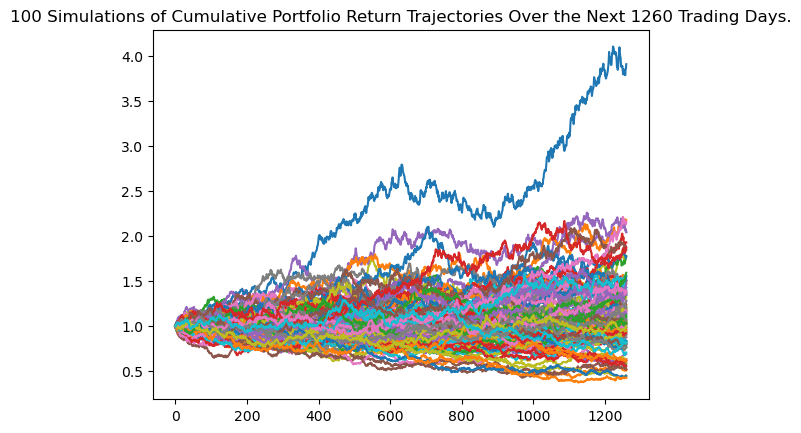

In [14]:
# Plot simulation outcomes
MC_att.plot_simulation()

<Axes: title={'center': 'Distribution of Final Cumuluative Returns Across All 100 Simulations'}, ylabel='Frequency'>

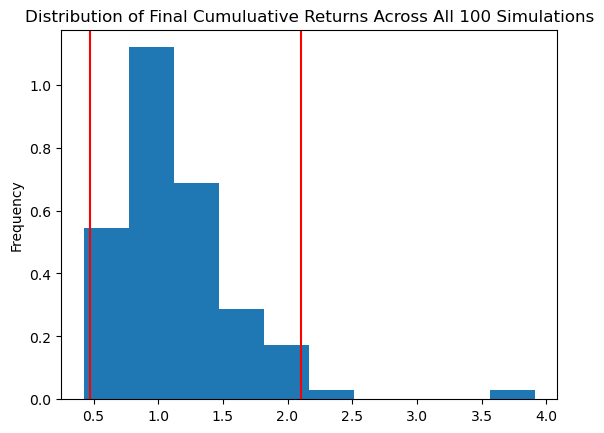

In [15]:
# Plot probability distribution and confidence intervals
MC_att.plot_distribution()

In [16]:
# Fetch summary statistics from the Monte Carlo simulation results
att_tbl = MC_even_dist.summarize_cumulative_return()
# Print summary statistics
print(att_tbl)

count           100.000000
mean              1.346102
std               0.514064
min               0.525769
25%               0.956150
50%               1.226156
75%               1.710420
max               2.914258
95% CI Lower      0.641431
95% CI Upper      2.477856
Name: 1260, dtype: float64


In [17]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
ci_lower = round(0.55*15000, 2)
ci_upper = round(2.45*15000, 2)

# Print results
print(f'There is a 95% chance to make within ${ci_lower} and ${ci_upper} with an initial investment of $15000')

There is a 95% chance to make within $8250.0 and $36750.0 with an initial investment of $15000


### Simulate five year portfolio growth with 60% Nike stock

In [18]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
MC_nike = MCSimulation(
    portfolio_data= df_ticker,
    weights= [.20, .60, .20],
    num_simulation= 100,
    num_trading_days= 252*5
)

# Printing the simulation input data
MC_nike.portfolio_data.head()

T                                             \
                           close   high    low trade_count   open    volume   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.10  39.70  39.06       95236  39.68  27137598   
2017-05-02 04:00:00+00:00  38.95  39.22  38.88       86239  39.14  26346738   
2017-05-03 04:00:00+00:00  38.40  38.98  38.15      113921  38.94  36621125   
2017-05-04 04:00:00+00:00  38.01  38.41  37.63      118192  38.41  32681751   
2017-05-05 04:00:00+00:00  38.56  38.71  38.03       82036  38.08  23262074   

                                                     NKE         ...  \
                                vwap daily_return  close   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.283136          NaN  54.99  55.45  ...   
2017-05-02 04:00:00+00:00  38.996146    -0.003836  55.07  55.16  ...   
2017-05-03 04:00:00+00:00  38.426498    -0.014121  54.53  55.30  ...   
2017-05-04 04:00:00+00:00  37.969998    -0.010156  54.47  54.83  ...   
2017-05-05 04:00:00+00:00  38.426797     0.014470  53.95  54.50  ...   

                                                     XOM                  \
                                vwap daily_return  close     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.190028          NaN  82.06  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.974022     0.001455  82.05  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.612038    -0.009806  82.70  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501759    -0.001100  81.64  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.898559    -0.009547  82.02  82.2350  81.61   

                                                                                
                          trade_count   open    volume       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00       49225  81.51   9769374  81.945427          NaN  
2017-05-02 04:00:00+00:00       54236  82.14  10044837  82.185586    -0.000122  
2017-05-03 04:00:00+00:00       57309  81.95  11189766  82.631674     0.007922  
2017-05-04 04:00:00+00:00       86290  82.29  17175853  81.728301    -0.012817  
2017-05-05 04:00:00+00:00       59390  81.64  11203370  81.940459     0.004655  

[5 rows x 24 columns]

In [19]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
MC_nike.calc_cumulative_return()

Running Monte Carlo simulation number 0.


Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.010018,0.989597,1.022597,0.997220,0.995309,0.992808,0.996132,1.005753,0.979479,0.988797,...,0.998020,1.021078,0.982420,0.998341,1.002668,1.001412,0.993868,0.988022,0.999214,1.018181
2,1.005460,0.993188,1.037900,0.976604,0.993733,1.007988,0.993411,0.989328,0.975454,0.963721,...,1.016172,1.036734,0.993628,1.012161,1.007997,0.992575,0.993892,1.005641,0.993717,1.019158
3,0.975229,0.989020,1.049830,0.977057,1.001124,1.001114,0.959193,0.993685,0.987818,0.971426,...,1.013108,1.027396,0.978847,1.013916,0.993911,0.997723,0.989046,1.022206,0.996570,0.982424
4,0.980265,1.004157,1.044467,0.999958,1.015266,1.001863,0.942433,0.991696,0.979556,0.978741,...,1.026415,1.020216,0.951671,1.022511,0.977954,1.003718,1.017506,1.022536,1.009833,0.985586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.886757,1.704487,2.961543,3.795462,4.449186,2.370623,2.064692,3.840360,1.847289,2.860904,...,1.692935,1.115586,2.889822,1.561265,1.983841,1.933196,2.126800,5.994243,1.523071,1.936368
1257,1.900391,1.725982,2.970741,3.783021,4.504813,2.339026,2.050996,3.869388,1.834166,2.836573,...,1.699045,1.094231,2.856737,1.546318,1.958649,1.938929,2.155823,5.936717,1.517453,1.938876
1258,1.912196,1.776719,2.970159,3.820527,4.532694,2.379443,2.033854,3.860276,1.800899,2.854689,...,1.669322,1.096613,2.867127,1.554109,1.946524,1.945418,2.166618,6.011864,1.534102,1.921653
1259,1.899801,1.789512,2.946813,3.790129,4.497589,2.434175,2.050574,3.828185,1.807612,2.850099,...,1.698039,1.086372,2.856517,1.571907,1.973564,1.940949,2.230761,5.939016,1.510890,1.958518


<Axes: title={'center': '100 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

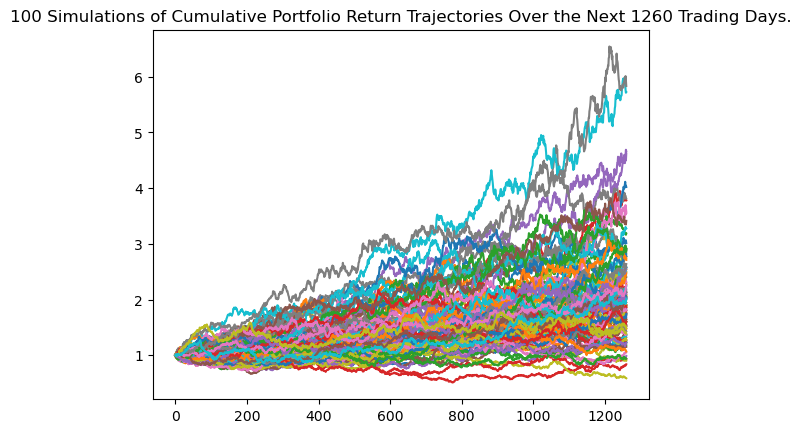

In [20]:
# Plot simulation outcomes
MC_nike.plot_simulation()

<Axes: title={'center': 'Distribution of Final Cumuluative Returns Across All 100 Simulations'}, ylabel='Frequency'>

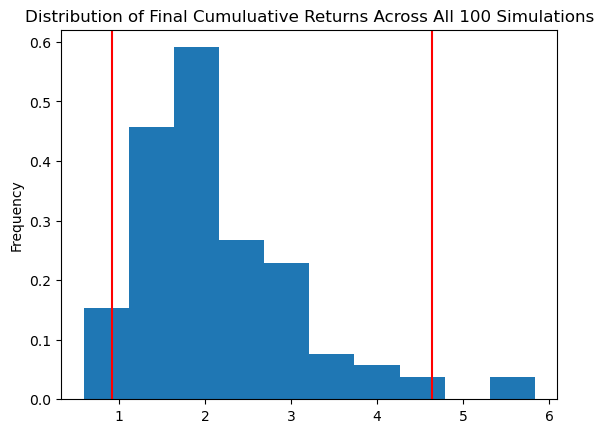

In [21]:
# Plot probability distribution and confidence intervals
MC_nike.plot_distribution()

In [22]:
# Fetch summary statistics from the Monte Carlo simulation results
nike_tbl = MC_even_dist.summarize_cumulative_return()

# Print summary statistics
print(nike_tbl)

count           100.000000
mean              1.346102
std               0.514064
min               0.525769
25%               0.956150
50%               1.226156
75%               1.710420
max               2.914258
95% CI Lower      0.641431
95% CI Upper      2.477856
Name: 1260, dtype: float64


In [23]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
ci_lower = round(0.8*15000, 2)
ci_upper = round(4.1*15000, 2)

# Print results
print(f'There is a 95% chance to make within ${ci_lower} and ${ci_upper} with an initial investment of $15000')

There is a 95% chance to make within $12000.0 and $61500.0 with an initial investment of $15000


### Simulate five year portfolio growth with 60% Exxon stock

In [24]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
MC_exxon = MCSimulation(
    portfolio_data= df_ticker,
    weights= [.20, .20, .60],
    num_simulation= 100,
    num_trading_days= 252*5
)

# Printing the simulation input data
MC_exxon.portfolio_data

T                                             \
                           close   high    low trade_count   open    volume   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.10  39.70  39.06       95236  39.68  27137598   
2017-05-02 04:00:00+00:00  38.95  39.22  38.88       86239  39.14  26346738   
2017-05-03 04:00:00+00:00  38.40  38.98  38.15      113921  38.94  36621125   
2017-05-04 04:00:00+00:00  38.01  38.41  37.63      118192  38.41  32681751   
2017-05-05 04:00:00+00:00  38.56  38.71  38.03       82036  38.08  23262074   
...                          ...    ...    ...         ...    ...       ...   
2021-04-26 04:00:00+00:00  30.91  31.38  30.89      135513  31.38  49836846   
2021-04-27 04:00:00+00:00  30.77  30.88  30.63      123680  30.84  35620696   
2021-04-28 04:00:00+00:00  30.96  31.15  30.90      105935  30.97  30983412   
2021-04-29 04:00:00+00:00  31.34  31.53  31.11      131112  31.13  40867496   
2021-04-30 04:00:00+00:00  31.41  31.43  31.05      103591  31.36  36203996   

                                                      NKE          ...  \
                                vwap daily_return   close    high  ...   
timestamp                                                          ...   
2017-05-01 04:00:00+00:00  39.283136          NaN   54.99   55.45  ...   
2017-05-02 04:00:00+00:00  38.996146    -0.003836   55.07   55.16  ...   
2017-05-03 04:00:00+00:00  38.426498    -0.014121   54.53   55.30  ...   
2017-05-04 04:00:00+00:00  37.969998    -0.010156   54.47   54.83  ...   
2017-05-05 04:00:00+00:00  38.426797     0.014470   53.95   54.50  ...   
...                              ...          ...     ...     ...  ...   
2021-04-26 04:00:00+00:00  31.017384    -0.015605  131.60  131.70  ...   
2021-04-27 04:00:00+00:00  30.743891    -0.004529  132.11  132.79  ...   
2021-04-28 04:00:00+00:00  31.004533     0.006175  130.71  132.33  ...   
2021-04-29 04:00:00+00:00  31.321181     0.012274  133.26  134.12  ...   
2021-04-30 04:00:00+00:00  31.304130     0.002234  132.62  133.88  ...   

                                                      XOM                  \
                                 vwap daily_return  close     high    low   
timestamp                                                                   
2017-05-01 04:00:00+00:00   55.190028          NaN  82.06  82.2100  81.48   
2017-05-02 04:00:00+00:00   54.974022     0.001455  82.05  82.5900  81.90   
2017-05-03 04:00:00+00:00   54.612038    -0.009806  82.70  83.0699  81.91   
2017-05-04 04:00:00+00:00   54.501759    -0.001100  81.64  82.3600  81.40   
2017-05-05 04:00:00+00:00   53.898559    -0.009547  82.02  82.2350  81.61   
...                               ...          ...    ...      ...    ...   
2021-04-26 04:00:00+00:00  130.967642     0.010830  55.68  56.2850  55.44   
2021-04-27 04:00:00+00:00  132.155497     0.003875  56.41  56.6300  55.81   
2021-04-28 04:00:00+00:00  130.796136    -0.010597  58.11  58.4600  56.79   
2021-04-29 04:00:00+00:00  132.982780     0.019509  58.94  59.4800  58.15   
2021-04-30 04:00:00+00:00  132.792989    -0.004803  57.24  58.8900  57.16   

                                                                                
                          trade_count   open    volume       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00       49225  81.51   9769374  81.945427          NaN  
2017-05-02 04:00:00+00:00       54236  82.14  10044837  82.185586    -0.000122  
2017-05-03 04:00:00+00:00       57309  81.95  11189766  82.631674     0.007922  
2017-05-04 04:00:00+00:00       86290  82.29  17175853  81.728301    -0.012817  
2017-05-05 04:00:00+00:00       59390  81.64  11203370  81.940459     0.004655  
...                               ...    ...       ...        ...          ...  
2021-04-26 04:00:00+00:00       93220  55.47  17400789  55.840598     0.001979 

In [25]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Exxon stock
MC_exxon.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.012875,0.991355,1.008015,0.983513,1.009922,1.019767,1.003250,0.999583,0.975377,0.993317,...,0.988643,1.011206,1.020610,1.003061,0.993887,0.998017,0.991694,0.986600,1.019786,0.993879
2,1.007733,0.980725,1.022782,1.003919,1.025965,1.020462,1.014119,0.992382,0.982802,0.995323,...,0.992814,0.987834,1.023270,1.014175,0.970372,0.984383,0.972797,0.963558,1.005094,0.996040
3,1.020335,0.966973,1.035219,1.006170,1.038131,0.998987,1.011983,1.004542,1.003720,1.003052,...,0.973236,0.980214,1.031087,1.019429,0.965769,0.993910,0.982129,0.972941,1.006746,0.971862
4,1.011473,0.979951,1.046873,1.010019,1.044635,0.991872,0.994430,0.995570,1.002155,0.997151,...,0.986190,0.997639,1.035405,1.023349,0.968239,1.001451,0.965388,0.959100,1.008127,0.961286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,0.768520,0.589952,1.179239,0.527122,0.584986,1.784525,0.593126,0.978130,0.602948,0.798593,...,0.637578,1.205187,1.201379,1.177991,0.700237,1.687295,1.994189,0.613384,0.709512,0.518267
1257,0.765833,0.596092,1.168032,0.532871,0.585405,1.742407,0.595820,0.994755,0.594414,0.787854,...,0.633517,1.210291,1.191001,1.180543,0.705275,1.674742,1.981768,0.607550,0.708014,0.517156
1258,0.769827,0.595480,1.170641,0.529025,0.577386,1.777275,0.597901,0.989844,0.591874,0.773701,...,0.636447,1.196052,1.201992,1.190302,0.704960,1.688777,1.961646,0.611312,0.704972,0.519824
1259,0.765635,0.600974,1.158033,0.526382,0.577647,1.770346,0.595280,0.994930,0.581978,0.769108,...,0.638270,1.210254,1.201323,1.189712,0.703217,1.722024,2.011476,0.619505,0.701920,0.506048


<Axes: title={'center': '100 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

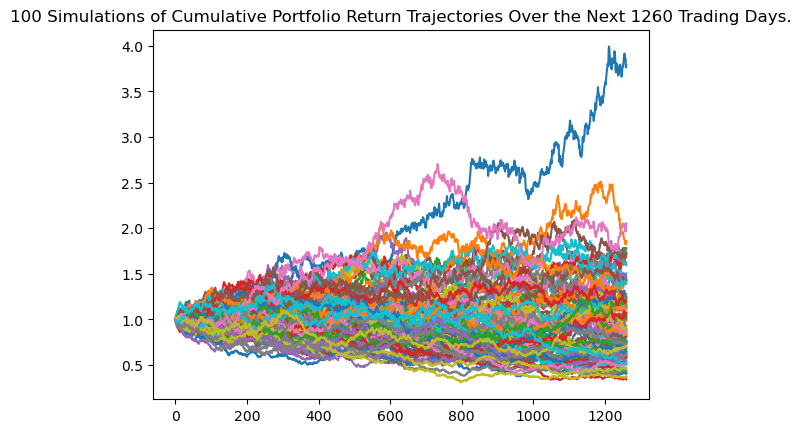

In [26]:
# Plot simulation outcomes
MC_exxon.plot_simulation()

<Axes: title={'center': 'Distribution of Final Cumuluative Returns Across All 100 Simulations'}, ylabel='Frequency'>

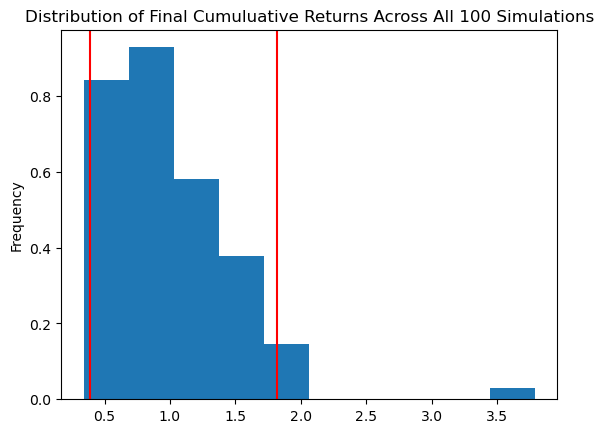

In [27]:
# Plot probability distribution and confidence intervals
MC_exxon.plot_distribution()

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
exxon_tbl = MC_even_dist.summarize_cumulative_return()

# Print summary statistics
print(exxon_tbl)

count           100.000000
mean              1.346102
std               0.514064
min               0.525769
25%               0.956150
50%               1.226156
75%               1.710420
max               2.914258
95% CI Lower      0.641431
95% CI Upper      2.477856
Name: 1260, dtype: float64


In [29]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
ci_lower = round(0.4*15000, 2)
ci_upper = round(2.52*15000, 2)

# Print results
print(f'There is a 95% chance to make within ${ci_lower} and ${ci_upper} with an initial investment of $15000')

There is a 95% chance to make within $6000.0 and $37800.0 with an initial investment of $15000


### Summarize findings across all 4 simulations

YOUR ANSWER HERE!

Invest all your money in NKE